<a href="https://colab.research.google.com/github/Sunitsable/Basic-Iphone-Price-predictor-using-Linear-regression-model/blob/main/Copy_of_Coe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 5.7 MB/s eta 0:00:00


#Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
data.head()

,id,text,complaint,demands,praise,questions
0,500796286320,Wow! From what I've observed from this documen...,0.0,0.0,1.0,0.0
1,838906157157,काय रे dungnat मेंदु असणाऱ्या आंधभक्ता तुझा आई...,1.0,0.0,0.0,0.0
2,1011026626743,अजित दादा आणि प्रफुल्ल पटेल यांनी केलेल्या काम...,0.0,0.0,1.0,0.0
3,1068853499446,"She's saying that ""doing her own research"" led...",1.0,0.0,0.0,0.0
4,502772748919,"That is not Karen, that is perfectly reasonabl...",1.0,0.0,0.0,0.0


In [ ]:
test_data.head()

,id,text
0,1041016773991,मोदी साहेब वरती चांगले तो पण त्यांच्या साईटला ...
1,109362481297,In #Jawan you will get: 1. 1st class action 2....
2,985019053532,किती दहशत आहे दोन्ही पवारांची बारामती कर मोकळे...
3,436629695381,आजवर का नाही विकास केलात मित्रा घरात किती प्रत...
4,585196067684,घराणेशाही थांबवायची असेल तर मोठ्या कॉलेज विद्य...


#Input Text Cleaning for better model performance

In [ ]:
ps = PorterStemmer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    text = " ".join([ps.stem(word) for word in text.split() if word not in stop_words])
    return text

data["text"] = data["text"].apply(clean_text)
test_data["text"] = test_data["text"].apply(clean_text)
print("Text cleaning completed!")

Text cleaning completed!


#Preprocessing of the comments using TfIdf(Term frequency- Inverse document frequency) technique

In [ ]:
tfIdf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words="english")
X_tfidf = tfIdf.fit_transform(data["text"])
X_test_tfidf = tfIdf.transform(test_data["text"])
print("TF-IDF vectorization completed!")

TF-IDF vectorization completed!


#Train test split

In [ ]:
y=data[["complaint", "demands", "praise", "questions"]]
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y,
                                                  test_size=0.2, random_state=42)
print("Data split into training and validation sets.")

Data split into training and validation sets.


#Training an ensemble voting model for each target column

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np

# Targets to resample
targets_to_resample = ['demands', 'questions']
models = {}

# Parameter grids for GridSearch
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

for target in y_train.columns:
    print(f"Training models for {target}...")

    # Extract target-specific data
    X_target = X_train.copy()
    y_target = y_train[target]

    # Handle imbalance using SMOTE followed by ENN
    if target in targets_to_resample:
        print(f"Handling imbalance for {target} using SMOTE and ENN...")

        # Step 1: Apply SMOTE for oversampling
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_target, y_target)

        # Step 2: Apply Edited Nearest Neighbors (ENN) to clean the data
        enn = EditedNearestNeighbours(n_neighbors=3)
        X_cleaned, y_cleaned = enn.fit_resample(X_resampled, y_resampled)

        X_target, y_target = X_cleaned, y_cleaned

    # Initialize models
    rf = RandomForestClassifier(random_state=42)
    gb = GradientBoostingClassifier(random_state=42)

    # Perform GridSearch to find the best hyperparameters
    grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='f1', n_jobs=-1)
    grid_search_gb = GridSearchCV(gb, param_grid_gb, cv=3, scoring='f1', n_jobs=-1)

    # Fit the grid search models
    grid_search_rf.fit(X_target, y_target)
    grid_search_gb.fit(X_target, y_target)

    # Best estimators after grid search
    best_rf = grid_search_rf.best_estimator_
    best_gb = grid_search_gb.best_estimator_

    # VotingClassifier with best models
    voting_model = VotingClassifier(
        estimators=[('rf', best_rf), ('gb', best_gb)],
        voting='soft'
    )

    # Train the VotingClassifier
    voting_model.fit(X_target, y_target)
    models[target] = voting_model

    # Evaluate model on validation data
    preds = models[target].predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val[target], preds)
    print(f"AUC for {target}: {auc:.4f}")


Training models for complaint...
AUC for complaint: 0.7871
Training models for demands...
Handling imbalance for demands using SMOTE and ENN...
AUC for demands: 0.7673
Training models for praise...
AUC for praise: 0.8556
Training models for questions...
Handling imbalance for questions using SMOTE and ENN...
AUC for questions: 0.7611


#Evaluation Metrics

Evaluating model for complaint...
Accuracy: 0.7013, Precision: 0.6780, Recall: 0.6575, F1-Score: 0.6676
Best threshold for complaint: 0.30
Optimized F1-Score for complaint: 0.7177


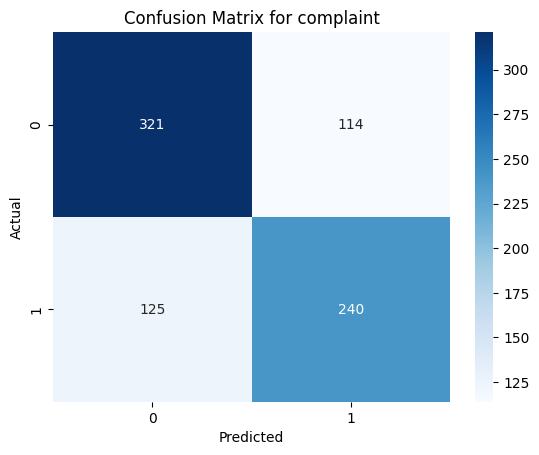

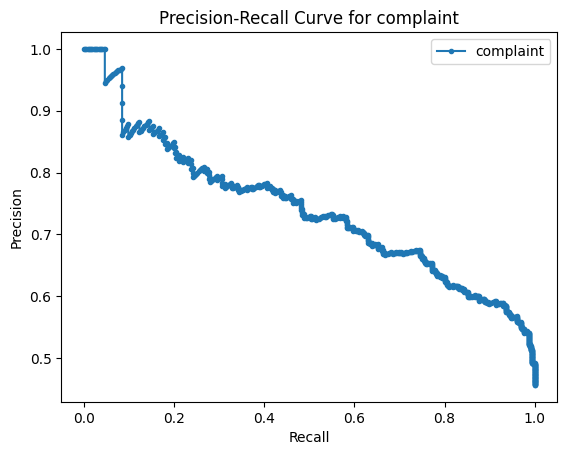

Evaluating model for demands...
Accuracy: 0.8812, Precision: 0.6364, Recall: 0.3182, F1-Score: 0.4242
Best threshold for demands: 0.30
Optimized F1-Score for demands: 0.4770


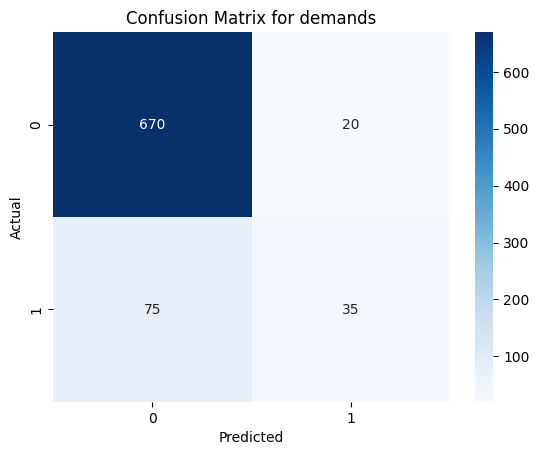

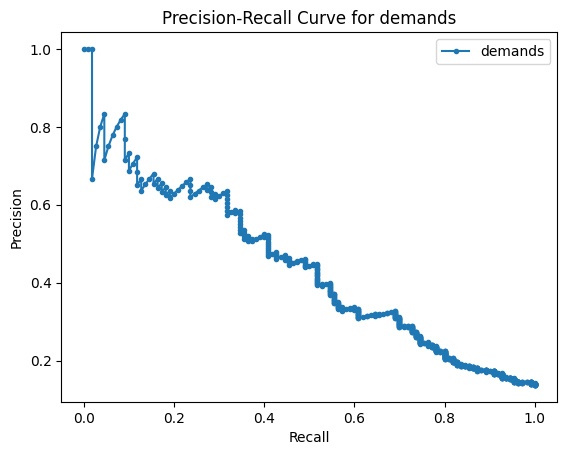

Evaluating model for praise...
Accuracy: 0.8075, Precision: 0.7600, Recall: 0.5429, F1-Score: 0.6333
Best threshold for praise: 0.30
Optimized F1-Score for praise: 0.6783


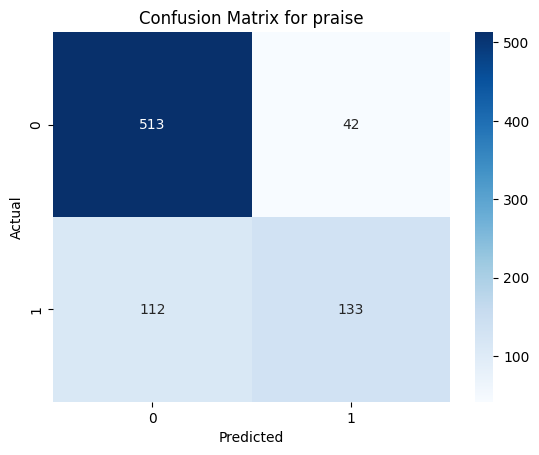

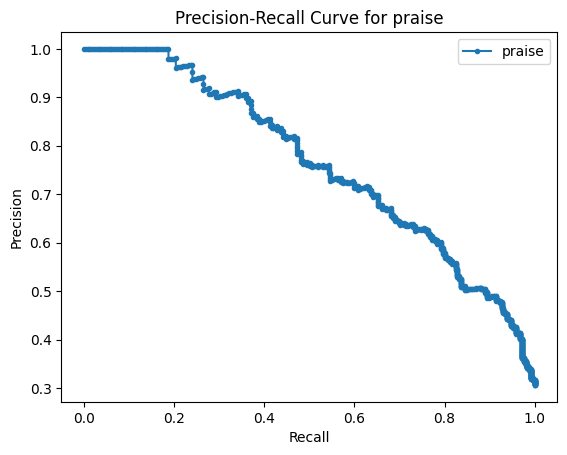

Evaluating model for questions...
Accuracy: 0.8988, Precision: 0.4839, Recall: 0.1875, F1-Score: 0.2703
Best threshold for questions: 0.20
Optimized F1-Score for questions: 0.4126


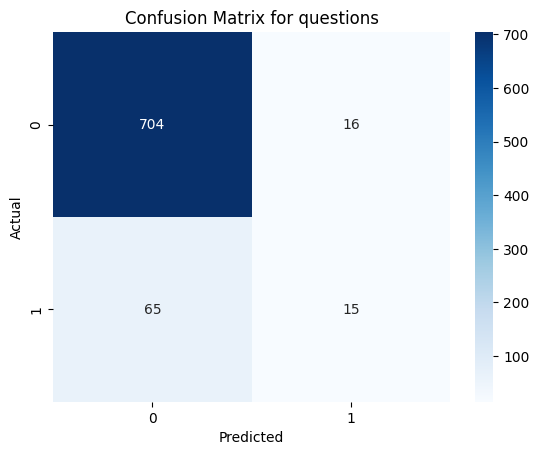

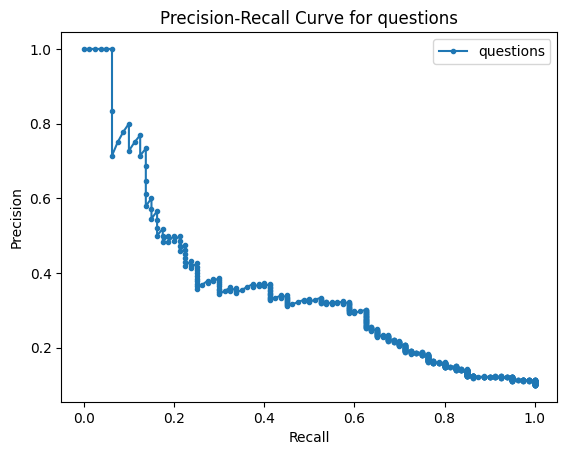

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

for target in y_val.columns:
    print(f"Evaluating model for {target}...")

    preds_binary = models[target].predict(X_val)
    preds_proba = models[target].predict_proba(X_val)[:, 1]


    accuracy = accuracy_score(y_val[target], preds_binary)
    precision = precision_score(y_val[target], preds_binary, zero_division=0)
    recall = recall_score(y_val[target], preds_binary, zero_division=0)
    f1 = f1_score(y_val[target], preds_binary, zero_division=0)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")


    best_threshold = 0.5
    f1_best = 0
    for threshold in np.arange(0.1, 1.0, 0.05):
        preds_thresholded = (preds_proba >= threshold).astype(int)
        f1_curr = f1_score(y_val[target], preds_thresholded, zero_division=0)
        if f1_curr > f1_best:
            f1_best = f1_curr
            best_threshold = threshold

    print(f"Best threshold for {target}: {best_threshold:.2f}")
    print(f"Optimized F1-Score for {target}: {f1_best:.4f}")


    cm = confusion_matrix(y_val[target], preds_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


    precision, recall, thresholds = precision_recall_curve(y_val[target], preds_proba)
    plt.plot(recall, precision, marker='.', label=f'{target}')
    plt.title(f'Precision-Recall Curve for {target}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()


In [ ]:
test_data["text"] = test_data["text"].apply(clean_text)
X_test_tfidf = tfIdf.transform(test_data["text"])

In [ ]:
submission_data = []

for target in y_train.columns:
    print(f"Generating predictions for {target}...")


    preds_proba = models[target].predict_proba(X_test_tfidf)[:, 1]


    submission_data.append(preds_proba)

submission_df = pd.DataFrame({
    'id': test_data['id'],
    'complaint': submission_data[0],
    'demands': submission_data[1],
    'praise': submission_data[2],
    'questions': submission_data[3]
})

submission_df[['complaint', 'demands', 'praise', 'questions']] = submission_df[['complaint', 'demands', 'praise', 'questions']].clip(0, 1)

submission_df.to_csv("submission.csv", index=False)

print("Submission file saved as 'submission.csv'.")


Generating predictions for complaint...
Generating predictions for demands...
Generating predictions for praise...
Generating predictions for questions...
Submission file saved as 'submission.csv'.
